In [1]:
import pyprojroot
import sys

package_path = pyprojroot.here().__str__()
if package_path not in sys.path:
    sys.path.append(package_path)

In [90]:
import re
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import LoadData, AbsPaths

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
final_data='operational_rdbms.csv'
df = LoadData().from_csv(file_name=final_data)
df.loc[:,'tourney_name']=df.tourney_name.str.upper() ###AGREGAR A CALIDAD DE DATOS.

In [13]:
df.head()

,tourney_date,tourney_name,surface,id,ht,wg,age,rank,minutes_played,pj,pg,pp,round
0,2000-01-17,AUSTRALIAN OPEN,Hard,101086.0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,128
1,2000-01-17,AUSTRALIAN OPEN,Hard,101150.0,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,64
2,2000-01-17,AUSTRALIAN OPEN,Hard,101185.0,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,64
3,2000-01-17,AUSTRALIAN OPEN,Hard,101463.0,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,128
4,2000-01-17,AUSTRALIAN OPEN,Hard,101532.0,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,32


In [14]:
def one_hot_codification(data:pd.DataFrame, variable:str):

    new_variables= pd.get_dummies(data[variable], drop_first=True)
    data.loc[:,new_variables.columns]=new_variables
    data=data.drop(columns=variable)
    #data=pd.concat([data.drop(columns=variable),new_variables],axis=1)
    return data

In [16]:
def ordinal_codification(data:pd.DataFrame, variable:str):

    for i,j in enumerate(np.sort(df[variable].unique())):
        data.loc[data[variable]==j,variable+'_cod']=i
    
    data=data.drop(columns=variable)
    return data

In [17]:
def config_inputs(data, nominal_variables=None, ordinal_variables=None):
    if nominal_variables==None:
        nominal_variables=['surface', 'tourney_name']#,'id']
    if ordinal_variables==None:
        ordinal_variables=['round','tourney_date','id']
    for i in nominal_variables:
        data=one_hot_codification(data, i)
    for i in ordinal_variables:
        data=ordinal_codification(data,i)

    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower().replace(' ', '_') for col in data.columns.str.lower()]
    return data

In [18]:
df2=config_inputs(df)

C:\Users\johnm\AppData\Local\Temp\ipykernel_7792\1217108403.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables
C:\Users\johnm\AppData\Local\Temp\ipykernel_7792\1217108403.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables


In [19]:
df2.head()

,ht,wg,age,rank,minutes_played,pj,pg,pp,grass,hard,roland_garros,us_open,wimbledon,round_cod,tourney_date_cod,id_cod
0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,1.0
1,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,2.0
2,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,3.0
3,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,5.0
4,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,0,1,0,0,0,4.0,0.0,6.0


In [37]:
def make_train_test_split(x, y, test_size = 0.25, random_state = 42):

    (x_train, x_test, y_train, y_test) = train_test_split(
        x,
        y,
        test_size=test_size,
        random_state=random_state,
    )
    return x_train, x_test, y_train, y_test

In [173]:
def eval_metrics(y_true, y_pred, y_preb_probs, 
                 labels = None):

    class_report = classification_report(y_true, y_pred, labels=labels)
    roc_auc_score_ = roc_auc_score(y_true, y_preb_probs, average="weighted", multi_class="ovr")
    print(roc_auc_score)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return class_report, roc_auc_score_, mse, mae, r2


In [174]:
def report(estimator, class_report, roc_auc_score_, mse, mae, r2):
    print(estimator, ":", sep="")
    print(f"Classification report: \n {class_report}")
    print(f"  ROC AUC score: {roc_auc_score_}")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R2: {r2}")


In [175]:
def save_best_estimator(estimator, 
                        estimator_name='estimator.pkl',
                        models_path=None 
                        ):

    if models_path is None:
        try:
            models_path = AbsPaths().get_abs_path_folder('models')
        except:
            models_path = AbsPaths().parent_path+os.sep+'models'
            os.makedirs(models_path)

    with open(models_path+estimator_name, "wb") as file:
        pickle.dump(estimator, file)

In [176]:
def load_best_estimator(estimator_name='estimator.pkl'):
    try:
        estimator_path = AbsPaths().get_abs_path_file(estimator_name)
    except:
        return None
    
    with open(estimator_path, 'rb') as fp:
        estimator = pickle.load(fp)
        return estimator


In [177]:
def train_estimator(param_grid, x, y,
                    n_iter=5, 
                    n_splits=5, 
                    verbose=1, 
                    path_img=None, 
                    class_names=None,
                    estimator_name='estimator.pkl'):

    x_train, x_test, y_train, y_test = make_train_test_split(x=x, y=y)

    # ------------------------------------------------
    # Búsqueda de parámtetros con validación cruzada

    estimator = RandomizedSearchCV(
        estimator=RandomForestClassifier(
            random_state = 42,
        ),
        param_distributions = param_grid,
        n_iter = n_iter,
        cv = n_splits,
        refit = True,
        verbose = 0 
    )

    # ------------------------------------------------
    estimator.fit(x_train, y_train)

    estimator = estimator.best_estimator_

    class_report, roc_auc_score_, mse, mae, r2 = eval_metrics(y_true=y_test,
                                                              y_pred=estimator.predict(x_test),
                                                              y_preb_probs=estimator.predict_proba(x_test))

    
    if verbose > 0 :
        report(estimator, class_report, roc_auc_score_, mse, mae, r2)

    if class_names is None:
        class_names = y_train.unique()

    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        estimator,
        x_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None,
        )
    
    if path_img is None:
        try:
            path_img=AbsPaths().get_abs_path_folder(folder_name='figures')
        except:
            path_img = AbsPaths().parent_path+os.sep+'figures'
            os.makedirs(path_img)
    
    plt.savefig(path_img + 'confusion_matrix.png')
    plt.show()

    # Compare against the last best estimator
    best_estimator = load_best_estimator(estimator_name=estimator_name)
    if (best_estimator is None) or (estimator.score(x_test, y_test) > best_estimator.score(x_test, y_test)):
        best_estimator = estimator
        save_best_estimator(estimator=best_estimator, estimator_name=estimator_name)



In [194]:
param_grid = { 
    'n_estimators': [100, 200, 250, 500],
    # 'max_features': ['sqrt', 'log2'],
    # 'min_samples_split': np.arange(2,16,2),
    'max_depth' : np.arange(1,28,4),
    'criterion' :['gini', 'entropy','log_loss'],
    'class_weight':['balanced', 'balanced_subsample']
}

In [195]:
class_names=list(map(lambda x: 'R-'+str(x) , list(sorted(set(df['round'])))))
class_names

['R-1', 'R-2', 'R-4', 'R-16', 'R-32', 'R-64', 'R-128']

<function roc_auc_score at 0x000001EE95381FC0>
RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=17, n_estimators=500, random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.42      0.36      0.39        36
         1.0       0.07      0.03      0.04        37
         2.0       0.05      0.03      0.04        74
         3.0       0.19      0.14      0.16       117
         4.0       0.27      0.16      0.20       258
         5.0       0.24      0.09      0.13       544
         6.0       0.59      0.87      0.70      1142

    accuracy                           0.50      2208
   macro avg       0.26      0.24      0.24      2208
weighted avg       0.42      0.50      0.44      2208

  ROC AUC score: 0.657596516611239
  MSE: 1.662590579710145
  MAE: 0.7803442028985508
  R2: 0.08714995414108695


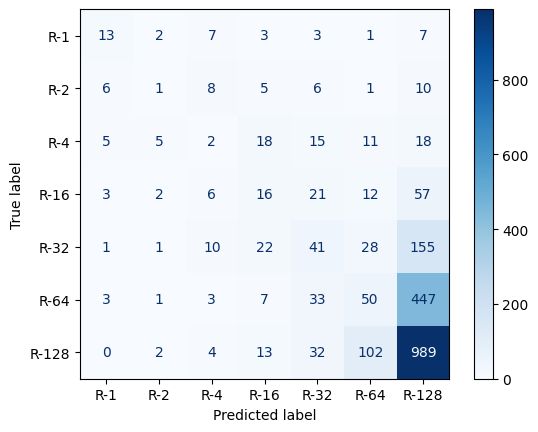

In [196]:
x=df2.drop(columns='round_cod')
y=df2.round_cod

train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)

<function roc_auc_score at 0x000001EE95381FC0>
RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=250,
                       random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.47      0.42      0.44        36
         1.0       0.08      0.05      0.07        37
         2.0       0.10      0.05      0.07        74
         3.0       0.14      0.16      0.15       117
         4.0       0.25      0.25      0.25       258
         5.0       0.24      0.13      0.17       544
         6.0       0.62      0.77      0.69      1142

    accuracy                           0.48      2208
   macro avg       0.27      0.26      0.26      2208
weighted avg       0.43      0.48      0.44      2208

  ROC AUC score: 0.6657776470582905
  MSE: 1.551177536231884
  MAE: 0.7857789855072463
  R2: 0.14832159981836635


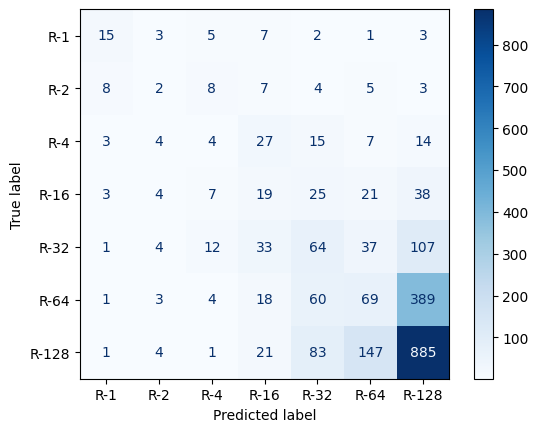

In [197]:
x=df2.drop(['round_cod', 'id_cod'], axis=1)
y=df2['round_cod']

train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1,
    estimator_name='estimator2.pkl'
)